In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os
import sys
sys.path.append('/Users/datnguyen/Work/others/')

from utils.db_utils import df_from_snowflake
import matplotlib.pyplot as pp

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from chow_test import chow_test
pd.set_option('display.max_rows', None)

/Users/datnguyen/.pyenv/versions/3.11.5/envs/analytics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
query= """
with raw_response_unique as (
    select distinct EXPORT_UPDATED_AT_UTC as response_ts
     from stage.main_marketing.adwords_offline_conversions_feedback
     where true
       and EXPORT_UPDATED_AT_UTC >= '2023-01-01'
)

select response_ts,
        lead(response_ts) over( order by response_ts asc) as next,
        lead(response_ts) over(partition by date_trunc('day',response_ts) order by response_ts asc) as next_intraday,
        datediff('hour',response_ts, next) as diff_in_hours,
        datediff('hour',response_ts, next_intraday) as diff_in_hours_intraday
from raw_response_unique
order by response_ts asc
"""

In [5]:
df_1 = df_from_snowflake(query=query)
df_1.tail(20)

,RESPONSE_TS,NEXT,NEXT_INTRADAY,DIFF_IN_HOURS,DIFF_IN_HOURS_INTRADAY
1960,2024-10-31 21:52:56.801,2024-11-01 03:58:00.530,NaT,6.0,NaN
1961,2024-11-01 03:58:00.530,2024-11-01 16:11:12.717,2024-11-01 16:11:12.717,13.0,13.0
1962,2024-11-01 16:11:12.717,2024-11-01 21:45:14.511,2024-11-01 21:45:14.511,5.0,5.0
1963,2024-11-01 21:45:14.511,2024-11-02 03:54:17.182,NaT,6.0,NaN
1964,2024-11-02 03:54:17.182,2024-11-02 20:11:59.779,2024-11-02 20:11:59.779,17.0,17.0
1965,2024-11-02 20:11:59.779,2024-11-02 21:52:45.745,2024-11-02 21:52:45.745,1.0,1.0
1966,2024-11-02 21:52:45.745,2024-11-03 04:16:19.823,NaT,7.0,NaN
1967,2024-11-03 04:16:19.823,2024-11-03 19:41:01.261,2024-11-03 19:41:01.261,15.0,15.0
1968,2024-11-03 19:41:01.261,2024-11-03 22:05:24.565,2024-11-03 22:05:24.565,3.0,3.0
1969,2024-11-03 22:05:24.565,2024-11-04 04:04:54.849,NaT,6.0,NaN


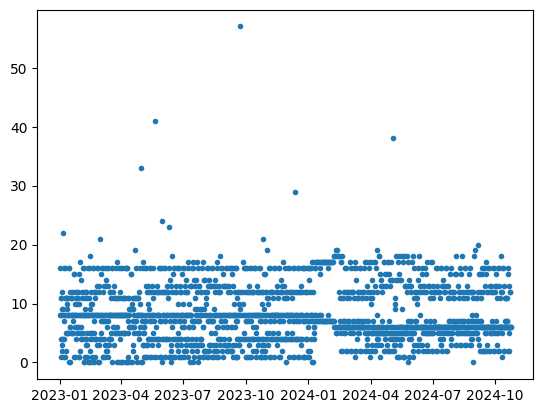

In [72]:
pp.plot(
    df_1['RESPONSE_TS'],
    df_1['DIFF_IN_HOURS'],
    '.',
    label='diff_hours'
)


(array([131.,  87.,  80., 137., 149., 273., 403.,  24.,  21.,  88., 166.,
         78.,  57., 143.,  58.,  24.,   6.,   1.,   3.,   1.,   1.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([ 0.        ,  1.16326531,  2.32653061,  3.48979592,  4.65306122,
         5.81632653,  6.97959184,  8.14285714,  9.30612245, 10.46938776,
        11.63265306, 12.79591837, 13.95918367, 15.12244898, 16.28571429,
        17.44897959, 18.6122449 , 19.7755102 , 20.93877551, 22.10204082,
        23.26530612, 24.42857143, 25.59183673, 26.75510204, 27.91836735,
        29.08163265, 30.24489796, 31.40816327, 32.57142857, 33.73469388,
        34.89795918, 36.06122449, 37.2244898 , 38.3877551 , 39.55102041,
        40.71428571, 41.87755102, 43.04081633, 44.20408163, 45.36734694,
        46.53061224, 47.69387755, 48.85714286, 50.02040816, 51.18367347,
       

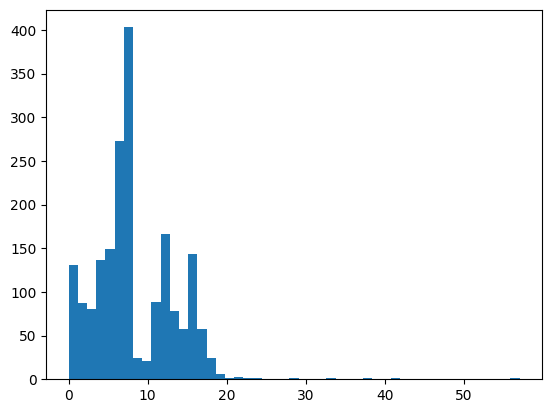

In [75]:
pp.hist(df_1['DIFF_IN_HOURS'], bins=49)

In [119]:
query_2 = """
with raw_response_unique as (
    select distinct EXPORT_UPDATED_AT_UTC as response_ts
     from stage.main_marketing.adwords_offline_conversions_feedback
     where true
       and EXPORT_UPDATED_AT_UTC >= '2022-01-01'
),
diffs as (
    select response_ts,
     lead(response_ts) over ( order by response_ts asc)                                            as next,
     lead(response_ts)
          over (partition by date_trunc('day', response_ts) order by response_ts asc)              as next_intraday,
     datediff('hour', response_ts, next)                                                           as diff_in_hours,
     datediff('hour', response_ts, next_intraday)                                                  as diff_in_hours_intraday
    from raw_response_unique
    order by response_ts asc
),
    cte_delay as (
        select
            date_trunc('day', response_ts) as dt,
            avg(diff_in_hours) mean,
            stddev(diff_in_hours) std,
            max(diff_in_hours) max,
            avg(diff_in_hours_intraday) mean_intraday,
            stddev(diff_in_hours_intraday) std_intraday,
            max(diff_in_hours_intraday) max_intraday,
            sum(diff_in_hours_intraday) sum_intraday,
            case
                when max_intraday > 12 + {allowance} then 1
                when sum_intraday < 16 - {allowance} then 1
                when max >= 24 then 1
                else 0
            end delay
        from diffs
        group by 1
    ),

    rev as (
        select 
            date_trunc('day', click_id_timestamp) as dt,
            count(click_id) as clicks,
            sum(revenue_final) as revenue
        from STAGE.derived.micro_conversions_revenue
        where true
            and click_id_timestamp >= '2022-01-01'
            and session_google_click_id_30_days is not null
            and click_id_source in ('Clickout', 'Onsite-Booking', 'Onsite-Inquiry', 'Inline-Ad', 'Popunder')
        group by 1
        order by 1
    ),

    ads_report as (
        select
            date_trunc('day', date) as dt,
            sum(cost) as spend,
            sum(clicks) as clicks,
            sum(revenue) as revenue
        from  STAGE.derived_marketing.google_adwords_ads_report
        where true
            and date >= '2022-01-01'
        group by 1
        order by 1

    ),

    cte_final as (
        select *
        from cte_delay
        full join ads_report using (dt)
    )


select *
from cte_final
where dt < current_date()
order by dt
""".format(allowance=6)

In [120]:
df_2 = df_from_snowflake(query=query_2)

,DT,MEAN,STD,MAX,MEAN_INTRADAY,STD_INTRADAY,MAX_INTRADAY,SUM_INTRADAY,DELAY,SPEND,CLICKS,REVENUE
1025,2024-10-22,8.000000,3.464102,12.0,9.000000,4.242641,12.0,18,0.0,78464.010770,209531,109233.552673
1026,2024-10-23,8.000000,3.464102,12.0,9.000000,4.242641,12.0,18,0.0,68095.794181,195750,87414.252252
1027,2024-10-24,8.000000,3.464102,12.0,9.000000,4.242641,12.0,18,0.0,57723.070307,170877,84879.905453
1028,2024-10-25,8.000000,3.464102,12.0,9.000000,4.242641,12.0,18,0.0,43609.983822,136114,57633.185665
1029,2024-10-26,8.000000,7.211103,16.0,9.000000,9.899495,16.0,18,0.0,37317.946586,119548,60019.891942
1030,2024-10-27,8.000000,5.354126,13.0,6.333333,5.131601,12.0,19,0.0,42862.726202,151319,72665.450717
1031,2024-10-28,11.500000,7.778175,17.0,6.000000,NaN,6.0,6,1.0,35958.153936,129682,61856.191434
1032,2024-10-29,4.500000,2.380476,6.0,4.000000,2.645751,6.0,12,0.0,34285.891819,122132,54296.825752
1033,2024-10-30,8.000000,3.605551,12.0,9.500000,3.535534,12.0,19,0.0,32690.473023,111349,46158.734457
1034,2024-10-31,8.000000,3.464102,12.0,9.000000,4.242641,12.0,18,0.0,37971.610269,110656,56269.070004


In [131]:
df_2['LOG_REV'] = np.log(df_2['REVENUE'])


In [132]:
df_2.tail(20)

,DT,MEAN,STD,MAX,MEAN_INTRADAY,STD_INTRADAY,MAX_INTRADAY,SUM_INTRADAY,DELAY,SPEND,CLICKS,REVENUE,REV_PER_CLICK,LOG_REV
1025,2024-10-22,8.000000,3.464102,12.0,9.000000,4.242641,12.0,18,0.0,78464.010770,209531,109233.552673,0.521324,11.601244
1026,2024-10-23,8.000000,3.464102,12.0,9.000000,4.242641,12.0,18,0.0,68095.794181,195750,87414.252252,0.446561,11.378414
1027,2024-10-24,8.000000,3.464102,12.0,9.000000,4.242641,12.0,18,0.0,57723.070307,170877,84879.905453,0.496731,11.348993
1028,2024-10-25,8.000000,3.464102,12.0,9.000000,4.242641,12.0,18,0.0,43609.983822,136114,57633.185665,0.423418,10.961854
1029,2024-10-26,8.000000,7.211103,16.0,9.000000,9.899495,16.0,18,0.0,37317.946586,119548,60019.891942,0.502057,11.002431
1030,2024-10-27,8.000000,5.354126,13.0,6.333333,5.131601,12.0,19,0.0,42862.726202,151319,72665.450717,0.480214,11.193621
1031,2024-10-28,11.500000,7.778175,17.0,6.000000,NaN,6.0,6,1.0,35958.153936,129682,61856.191434,0.476984,11.032567
1032,2024-10-29,4.500000,2.380476,6.0,4.000000,2.645751,6.0,12,0.0,34285.891819,122132,54296.825752,0.444575,10.902221
1033,2024-10-30,8.000000,3.605551,12.0,9.500000,3.535534,12.0,19,0.0,32690.473023,111349,46158.734457,0.414541,10.739841
1034,2024-10-31,8.000000,3.464102,12.0,9.000000,4.242641,12.0,18,0.0,37971.610269,110656,56269.070004,0.508504,10.937900


In [121]:
df_2['DELAY'].sum()

43.0

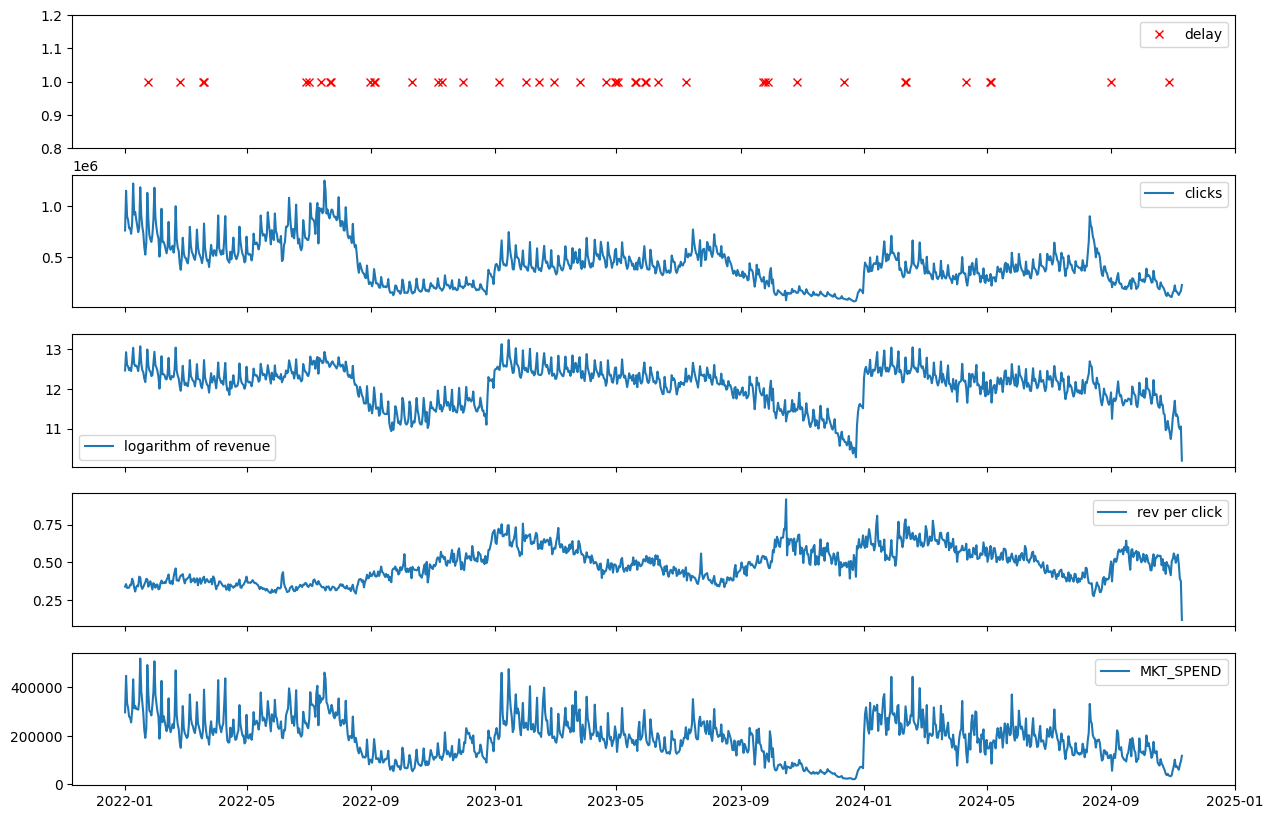

In [133]:
_, ax = pp.subplots(nrows=5, ncols=1, sharex=True, figsize=(15,10))

ax[0].plot(df_2['DT'],
           df_2['DELAY'],
           'x',
           label='delay',
           color='red'
           )
ax[0].set_ylim(0.8,1.2)

ax[1].plot(
    df_2['DT'],
    df_2['CLICKS'],
    label='clicks'
)

ax[2].plot(
    df_2['DT'],
    df_2['LOG_REV'],
    label='logarithm of revenue'
)

ax[3].plot(
    df_2['DT'],
    df_2['REVENUE']/df_2['CLICKS'],
    label='rev per click'
)

ax[4].plot(
    df_2['DT'],
    df_2['SPEND'],
    label='MKT_SPEND'
)

for i in ax:
    i.legend()


# Using Prophet

In [134]:
prophet_df = df_2[['DT','LOG_REV']]
prophet_df.columns = ['ds', 'y']
# prophet_df['y'].astype(float)

In [135]:
m = Prophet()
m.fit(prophet_df)

23:15:31 - cmdstanpy - INFO - Chain [1] start processing
23:15:31 - cmdstanpy - INFO - Chain [1] done processing


In [136]:
forecast = m.predict()
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1040,2024-11-06,11.191426,10.986621,11.390790
1041,2024-11-07,11.115426,10.901888,11.326448
1042,2024-11-08,11.060072,10.849506,11.265287
1043,2024-11-09,11.184023,10.977453,11.386366
1044,2024-11-10,11.493652,11.287316,11.704028


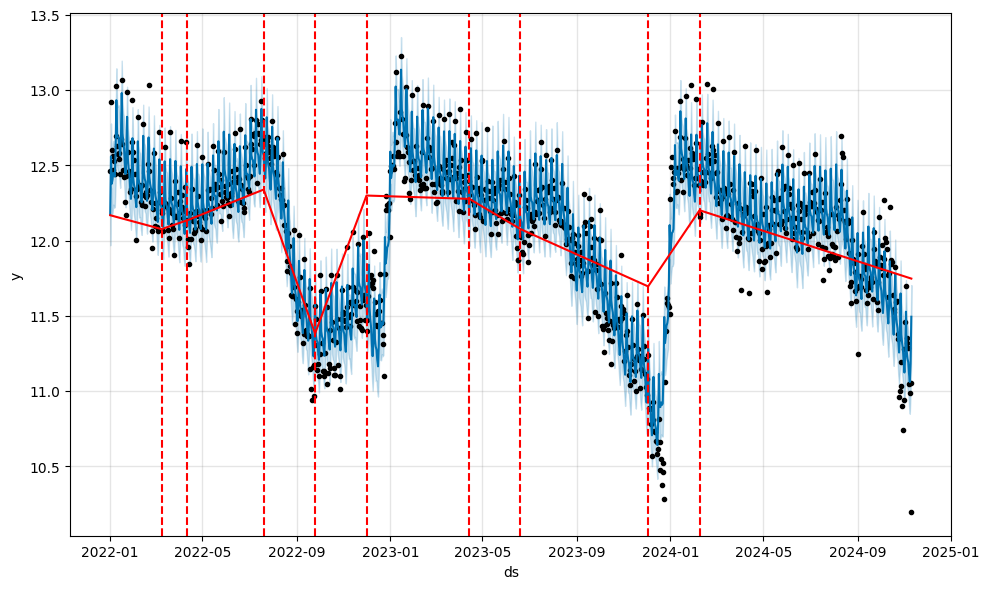

In [137]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [154]:
m.changepoints

33    2022-02-03
67    2022-03-09
100   2022-04-11
134   2022-05-15
167   2022-06-17
200   2022-07-20
234   2022-08-23
267   2022-09-25
301   2022-10-29
334   2022-12-01
367   2023-01-03
401   2023-02-06
434   2023-03-11
468   2023-04-14
501   2023-05-17
534   2023-06-19
568   2023-07-23
601   2023-08-25
635   2023-09-28
668   2023-10-31
701   2023-12-03
735   2024-01-06
768   2024-02-08
802   2024-03-13
835   2024-04-15
Name: ds, dtype: datetime64[ns]

In [102]:
df_2[['DT','DELAY']][df_2.DELAY == 1]

,DT,DELAY
23,2022-01-24,1.0
54,2022-02-24,1.0
77,2022-03-19,1.0
78,2022-03-20,1.0
139,2022-05-20,1.0
179,2022-06-29,1.0
182,2022-07-02,1.0
194,2022-07-14,1.0
197,2022-07-17,1.0
202,2022-07-22,1.0


## Chow test

In [65]:
# from statsmodels.tsa.seasonal import STL

# def decompose_seasonality(data,revenue_column):
#     """return residuals from decomposition process"""
#     stl = STL(data.iloc[:, revenue_column], period=365, seasonal=13, robust=True) 
#     result = stl.fit()
#     return result.resid, result.trend, result.seasonal 

In [156]:
# # DECOMPOSE
# df_2['REV_PER_CLICK'] = df_2['REVENUE']/df_2['CLICKS']

# stl = STL(df_2['REV_PER_CLICK'] , period=365, seasonal=13, robust=True) 
# result = stl.fit()
# result.plot()
# pp.show()

In [148]:

X = pd.DataFrame(df_2.index).fillna(0)
Y = pd.Series(df_2['LOG_REV']).astype('float')

# Y_hat = pd.Series(result.resid).astype('float')

#### TEST ON DELAY SIGNALS

In [149]:
chow_test(X_series=X, y_series=Y, last_index=1016, first_index=1017, significance=0.05)

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 27.461065954404486, P_value: 2.3880897259687117e-12


(27.461065954404486, 2.3880897259687117e-12)

In [150]:
chow_test(X_series=X, y_series=Y, last_index=866, first_index=867, significance=0.05)

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 29.52611080236532, P_value: 3.3717473257866004e-13


(29.52611080236532, 3.3717473257866004e-13)

In [151]:
chow_test(X_series=X, y_series=Y, last_index=833, first_index=834, significance=0.05)

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 26.207628488932496, P_value: 7.865041951049534e-12


(26.207628488932496, 7.865041951049534e-12)

#### TEST ON NORMAL SIGNALS

In [152]:
chow_test(X_series=X, y_series=Y, last_index=55, first_index=56, significance=0.05)

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 9.540353544723837, P_value: 7.838391356795871e-05


(9.540353544723837, 7.838391356795871e-05)

In [153]:
chow_test(X_series=X, y_series=Y, last_index=999, first_index=1000, significance=0.05)

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 26.37482209983458, P_value: 6.707856492482733e-12


(26.37482209983458, 6.707856492482733e-12)

## REGRESSION

In [81]:
import statsmodels.api as sm

In [157]:
input = df_2.fillna(0)
input = input.iloc[50:,]
input.exog = sm.add_constant(input[['DELAY','CLICKS', 'SPEND']])
input.endog = input['REV_PER_CLICK'].astype(float)

reg = sm.GLM(input.endog, input.exog, family=sm.families.Gamma())
result = reg.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          REV_PER_CLICK   No. Observations:                  995
Model:                            GLM   Df Residuals:                      991
Model Family:                   Gamma   Df Model:                            3
Link Function:           InversePower   Scale:                        0.016827
Method:                          IRLS   Log-Likelihood:                 1336.9
Date:                Tue, 12 Nov 2024   Deviance:                       17.334
Time:                        15:00:21   Pearson chi2:                     16.7
No. Iterations:                     6   Pseudo R-squ. (CS):             0.8740
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8379      0.021     89.518      0.0

/var/folders/lj/9ds87q3x3q15md0t2hlkfm_h0000gn/T/ipykernel_19013/1928672845.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  input.exog = sm.add_constant(input[['DELAY','CLICKS', 'SPEND']])
/var/folders/lj/9ds87q3x3q15md0t2hlkfm_h0000gn/T/ipykernel_19013/1928672845.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  input.endog = input['REV_PER_CLICK'].astype(float)
/Users/datnguyen/.pyenv/versions/3.11.5/envs/analytics/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


## EXTRA

In [22]:
query_3 = """
with
    tmp_clicks as (
        select 
            google_click_id,
            mkt_account_id as google_account_id
        from stage.main_marketing.mv_sem_performance_reports_google_clicks
        where true
        and mkt_date >= '2023-01-01'
        group by 1,2
    ),

    tmp_sessions as (
        with tmp_t1 as (
            select session_id,
                    site_id,
                    adword_30_days,
                    campaign_30_days,
                    google_click_id_30_days,
                    microsoft_click_id_30_days,
                    session_timestamp
                from stage.derived.sessions as sessions     
                where NVL(google_click_id_30_days, microsoft_click_id_30_days) IS NOT NULL
                    and session_timestamp >= '2023-01-01')
         select session_id,
                site_id,
                adword_30_days,
                campaign_30_days,
                google_click_id_30_days,
                microsoft_click_id_30_days,
                session_timestamp
         from tmp_t1
     ),
   

    tmp_aoc AS
        (
        -- Code block for calculating these conversion types: 'Clickout Value', 'Popunder Value'
            SELECT
                case
                    when mcr.session_google_click_id_30_days is not null then 'Google'
                    when mcr.session_microsoft_click_id_30_days is not null then 'Bing' end      as vendor_id,
                IFF(vendor_id = 'Google', tmp_clicks.google_account_id, null)                    as vendor_account_id,
                NVL(mcr.session_google_click_id_30_days, mcr.session_microsoft_click_id_30_days) as vendor_click_id,
                case
                    when mcr.click_id_source in ('Clickout', 'Onsite-Booking', 'Onsite-Inquiry', 'Inline-Ad') then
                        'Clickout Value'
                    when mcr.click_id_source = 'Popunder' then 'Popunder Value' end              AS conversionname,
                DATE_TRUNC('second', mcr.click_id_timestamp)                                     AS conversiontime,
                NVL(sum(ROUND(ecpc * 1.0 / 200, 3)), 0)                                          AS conversionvalue
            FROM STAGE.derived.micro_conversions_revenue as mcr
            JOIN tmp_sessions
                on mcr.session_id = tmp_sessions.session_id
            LEFT JOIN tmp_clicks 
                on nvl(mcr.session_google_click_id_30_days,'') = tmp_clicks.google_click_id 
            where true
                AND NVL(mcr.session_google_click_id_30_days, mcr.session_microsoft_click_id_30_days) IS NOT NULL
                AND mcr.ecpc > 0
                AND click_id_timestamp >= '2023-01-01'
            group by all

            UNION ALL

            -- Code block for calculating 'est_revenue'
            SELECT
                case
                    when mcr.session_google_click_id_30_days is not null then 'Google'
                    when mcr.session_microsoft_click_id_30_days is not null then 'Bing' end      as vendor_id,
                IFF(vendor_id = 'Google', google_account_id, null)                               as vendor_account_id,
                NVL(mcr.session_google_click_id_30_days, mcr.session_microsoft_click_id_30_days) as vendor_click_id,
                'est_revenue'                                                                    as conversionname,
                DATE_TRUNC('second', mcr.click_id_timestamp)                                     as conversiontime,
                NVL(sum(
                        case
                            when legal_entity_short_name in ('amivac','vacances','feries')  -- no halving factor for amivac, vacances and feries
                                then
                                    (
                                        coalesce(mcr.estimated_group_commission_after_cancellations_updated_eur, mcr.estimated_commission_reported_after_cancellations_updated_eur,0)
                                        + nvl(mcr.revenue_cpc,0) + nvl(mcr.revenue_add_ons,0) + nvl(mcr.revenue_service_fee,0)
                                    )
                            when regexp_like(tmp_sessions.adword_30_days, '^google/ch/.*|^cm_google/de/.*') = true-- direct cpa revenues for google campaigns on hometogo.ch and casamundo.de
                                then 
                                    (
                                        coalesce(mcr.estimated_group_commission_direct_after_cancellations_updated_eur, mcr.estimated_commission_reported_direct_after_cancellations_updated_eur,0)
                                        + nvl(mcr.revenue_cpc,0) + nvl(mcr.revenue_add_ons,0) + nvl(mcr.revenue_service_fee,0)
                                    )/ 2.0
                            else
                                (
                                    coalesce(mcr.estimated_group_commission_after_cancellations_updated_eur, mcr.estimated_commission_reported_after_cancellations_updated_eur,0)
                                    + nvl(mcr.revenue_cpc,0) + nvl(mcr.revenue_add_ons,0) + nvl(mcr.revenue_service_fee,0)
                                )/ 2.0
                end),0)::DECIMAL(10, 4) AS conversionvalue                 
            from STAGE.derived.micro_conversions_revenue as mcr
            JOIN tmp_sessions 
                on mcr.session_id = tmp_sessions.session_id
            LEFT JOIN tmp_clicks 
                on nvl(mcr.session_google_click_id_30_days,'') = tmp_clicks.google_click_id 
            where true
                and NVL(session_google_click_id_30_days, session_microsoft_click_id_30_days) IS NOT NULL
                and mcr.click_id_timestamp >= '2023-01-01'
                and tmp_sessions.legal_entity_short_name not in ('atraveo','bf','edomizil','to')
           group by all
            
            UNION ALL

            -- Code block for calculating 'est_revenue' for edomizil brands excluding Popunder revenues
            SELECT
                legal_entity_short_name,
                case
                    when mcr.session_google_click_id_30_days is not null then 'Google'
                    when mcr.session_microsoft_click_id_30_days is not null then 'Bing' end          as vendor_id,
                    IFF(vendor_id = 'Google', tmp_clicks.google_account_id, null)                    as vendor_account_id,
                    NVL(mcr.session_google_click_id_30_days, mcr.session_microsoft_click_id_30_days) as vendor_click_id,
                    'est_revenue'                                                                    as conversionname,
                    DATE_TRUNC('second', mcr.click_id_timestamp)                                     as conversiontime,
                    NVL(
                        sum(
                            coalesce(mcr.estimated_group_commission_direct_after_cancellations_updated_eur, estimated_commission_reported_direct_after_cancellations_updated_eur,0)
                            + nvl(mcr.revenue_add_ons,0) + nvl(mcr.revenue_service_fee,0)
                            ) 
                    ,0)::DECIMAL(10, 4)                                                         AS conversionvalue                 
            from STAGE.derived.micro_conversions_revenue as mcr
            JOIN tmp_sessions 
                on mcr.session_id = tmp_sessions.session_id 
            LEFT JOIN tmp_clicks 
                on nvl(mcr.session_google_click_id_30_days,'') = tmp_clicks.google_click_id 
            where true
                and NVL(session_google_click_id_30_days, session_microsoft_click_id_30_days) IS NOT NULL
                and mcr.click_id_timestamp >= '2023-01-01'
                and tmp_sessions.legal_entity_short_name in ('atraveo','bf','edomizil','to')
                and mcr.click_id_source not in ('Popunder','Onsite-Inquiry')
            group by all


            UNION ALL
            -- Code block for calculating 'est_revenue' for unqualified VRBO bookings 

            SELECT
                legal_entity_short_name,
                case
                    when ub.session_google_click_id_30_days is not null then 'Google'
                    when ub.session_microsoft_click_id_30_days is not null then 'Bing' end          as vendor_id,
                IFF(vendor_id = 'Google', tmp_clicks.google_account_id, null)                       as vendor_account_id,
                NVL(ub.session_google_click_id_30_days, ub.session_microsoft_click_id_30_days)      as vendor_click_id,
                'est_revenue'                                                                       as conversionname,
                DATE_TRUNC('second', ub.click_id_timestamp)                                         as conversiontime,
                NVL(sum(imputed_revenue_after_cancellations_adjusted/2),0)::DECIMAL(10, 4)          as conversionvalue                 
            from STAGE.derived_marketing.v_unqualified_bookings_imputed_values as ub
            JOIN tmp_sessions 
                on ub.session_id = tmp_sessions.session_id
            LEFT JOIN tmp_clicks 
                on nvl(ub.session_google_click_id_30_days,'') = tmp_clicks.google_click_id 
            where true
                and nvl(ub.session_google_click_id_30_days, ub.session_microsoft_click_id_30_days) IS NOT NULL
                and ub.click_id_timestamp >= '2023-01-01'
            group by all


            UNION ALL

            -- Code block for calculating 'prepaid_limited_revenue' for feries
            SELECT
                legal_entity_short_name,
                'Google'                                                                        as vendor_id,
                IFF(vendor_id = 'Google', tmp_clicks.google_account_id, null)                   as vendor_account_id,
                mcr.session_google_click_id_30_days                                             as vendor_click_id,
                'prepaid_limited_revenue'                                                       as conversionname,
                DATE_TRUNC('second', mcr.click_id_timestamp)                                    as conversiontime,
                sum(nvl(cvsr.subscription_revenue_direct_attribution,0))::DECIMAL(10, 4)        as conversionvalue                 
            from STAGE.derived.micro_conversions_revenue as mcr
            JOIN tmp_sessions 
                on mcr.session_id = tmp_sessions.session_id
            join STAGE.derived_finance.cv_subscription_revenue cvsr
                on mcr.click_id = cvsr.click_id
            LEFT JOIN tmp_clicks 
                on nvl(mcr.session_google_click_id_30_days,'') = tmp_clicks.google_click_id 
            where true
                and session_google_click_id_30_days IS NOT NULL
                and mcr.click_id_timestamp >= '2023-01-01'
                and tmp_sessions.legal_entity_short_name in ('feries', 'hometogo')
                and mcr.click_id_source = 'Onsite-Inquiry'
                and cvsr.subscription_type = 'B2C_limited_leads'
            group by all

            union all
            
            -- Code block for calculating these conversion types: 'est_bookings'
            SELECT
                legal_entity_short_name,
                case
                    when mcr.session_google_click_id_30_days is not null then 'Google'
                    when mcr.session_microsoft_click_id_30_days is not null then 'Bing' end      as vendor_id,
                IFF(vendor_id = 'Google', tmp_clicks.google_account_id, null)                    as vendor_account_id,
                NVL(mcr.session_google_click_id_30_days, mcr.session_microsoft_click_id_30_days) as vendor_click_id,
                'est_bookings'                                                                   as conversionname,
                DATE_TRUNC('second', mcr.click_id_timestamp)                                     as conversiontime,
                NVL(sum(mcr.booking_quantity_before_cancellations::DECIMAL(10, 4)), 0)           AS conversionvalue
            FROM STAGE.derived.micro_conversions_revenue as mcr
            JOIN tmp_sessions 
                on mcr.session_id = tmp_sessions.session_id
            LEFT JOIN tmp_clicks 
                on nvl(mcr.session_google_click_id_30_days,'') = tmp_clicks.google_click_id 
            where true
                AND NVL(mcr.session_google_click_id_30_days, mcr.session_microsoft_click_id_30_days) IS NOT NULL
                AND click_id_timestamp >= '2023-01-01'
            group by all

        )


select
       cast(convert_timezone('UTC',getdate()) as datetime) AS updated_at_utc,
       current_user                                        AS updated_by,
       legal_entity_short_name,
       vendor_id,
       vendor_account_id,
       vendor_click_id,
       conversionname,
       conversiontime,
       conversionvalue
from tmp_aoc
"""

In [57]:
df_3 = df_from_snowflake(query=query_3)
df_3

ProgrammingError: 000904 (42000): SQL compilation error: error line 39 at position 16
invalid identifier 'LEGAL_ENTITY_SHORT_NAME'